In [1]:
import sys
sys.path.append('/home/lpodgorsek/mag/scripts')

from relationGraph import Relation, RelationGraph, MatrixOfRelationGraph
from autoencoder import seedy, AutoEncoder
import utilityFunctions as uf
from main import test_build_relation_graph_with_symertic_data, test_convert_graph_to_2D_matrix, test_get_matix_for_autoencoder, test_autoencoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from base import load_source
from base2 import load_dicty, load_pharma
import utilityFunctions as uf
import autoencoder as ae
import multimodal as mm


from os.path import join
import numpy as np
import multiprocessing

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import mean_squared_error
from fastcluster import linkage
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Layer, Reshape, UpSampling2D, Flatten, Masking, Dropout, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow import set_random_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.utils import multi_gpu_model

numOfExperiment = 30
# path_data = '/data/samples/multiple_inputs_clustering/dicty/'
path_data = '/home/lpodgorsek/data/cnn/dicty/'

%load_ext autoreload
%autoreload 2

In [2]:
graph1 = load_dicty('clustering', 2)
# graph2 = load_pharma()

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1219
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	116
0	
1	ann-(1024, 128)
Experimental condition	282
0	
1	expr-(1024, 256)



In [4]:
def select_N_cells(data, num_of_cells):
    # data = (1,1024,128,1)
    # num_of_cells = 10
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    rand_vector = np.random.choice(np.flatnonzero(data_flatten), num_of_cells, replace=False)
    removed_cells = []
    
    for i in range(len(rand_vector)):
#         x = int(rand_vector[i] / col)
#         y = rand_vector[i] % col
        v = data_flatten[rand_vector[i]]
        
#         removed_cells.append((x,y,v))
        removed_cells.append((rand_vector[i], v))
        
    return removed_cells

def remove_cells_from_data(data, list_of_cells):
    # data = (1,1024,128,1)
    # list_of_cells = [(111, 1.0), (2244, 0.34), ...]
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    for index, _ in list_of_cells:
        data_flatten[index] = 0
        
    return data.reshape(1, row, col, 1)
        
    
    

def data_generator(filenames, org_data, batch_size=1, testing_cells=None, removed_cells=False):
    # n_pack => 1 samples of matrix
    # n_pack = batch_size
    # org_data = [[1,1024,128,1], [1,1024,256,1], [1,1024,1024,1]]
    # testing_cells = [[(111, 1.0), (2244, 0.34), ...], [(111, 1.0), (2244, 0.34), ...], ...]
    
    files = []              # different files
    num_packs = []          # subpacked inside of file
    for filename in filenames:
        f = np.load(filename)
        files.append(f)  
        num_packs.append(f.files)
    
    counter = 0
    while True:
        x = []
        y = []
        for i in range(len(files)):
            _x = []
            _y = []
            for j in range(batch_size):
                rand_num = np.random.randint(len(num_packs[i]))
                f = files[i]
                pack = num_packs[i]
                data = f[pack[rand_num]] 
                
                if testing_cells is not None and removed_cells:
                    data = remove_cells_from_data(data, testing_cells[i])

    #             new_data = top_N_rows(data)
    #             x.append(new_data)
                _, row, col, _ = data.shape
                if col != 1021:
                    _x.append(f[pack[rand_num]])
                    _y.append(org_data[i])
            
            _x = np.asarray(_x)
            _y = np.asarray(_y)

            _x = _x[:, 0, :, :, :]
            _y = _y[:, 0, :, :, :]
        
            x.append(_x)
            y.append(_y)
            
        yield (x, y)
        
            
def top_N_rows(data, rows=100):
    _, row, col, _ = data.shape
    rows = row
    remove_col = col % 6
    data = data.reshape(row, col)
    new_data = data[:rows, :(col - remove_col)]
    return new_data.reshape(1, rows, col - remove_col, 1)
    
    
def shuffle_data(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        np.random.shuffle(tmp_data)  # shuffle org data
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data


def replace_and_shuffle_data_with_random(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        tmp_data[tmp_data > 0] = 1;   # set nonzero values to 1
        tmp_data = tmp_data * np.random.rand(len(tmp_data))  # multiply with random vecotor
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data

    
def order_inputs(model, org_data):
    new_order_data = []
    for inp in model.inputs:
        _, x, y, _ = inp.shape
        for data in org_data:
            _, row, col, _ = data.shape
            if x == row and y == col:
                new_order_data.append(np.array(data).reshape(1,row,col,1))
                break

    return new_order_data


def duplicateBatchData(data, batch=2):
    new_data = []
    for i in range(len(data)):
        b = []
        for j in range(batch):
            b.append(data[i])

        b = np.asarray(b)
        b = b[:,0,:,:,:]

        new_data.append(b)
        
    return new_data;

    
class MultiModal:
    
    def __init__(self, graph=None, path=''):
        self.input_visibles = []
        self.input_layers = []
        self.outputs_layers = []
        self.input_data_size = []
        self.filenames = []
        self.inputs = None
        self.model = None
        self.path = path
        self.folder = path
        self.graph = graph
        self.org_data = []
        self.predict_data = []
        self.base_line = []
        self.shuffled_data = []
        self.dropout = 0.5
        self.num_of_seved_cells = 20
        self.saved_cells_for_test = []
        self.is_first_iteration = True
        self.fake_org_data = []
        self.activation = 'relu'
        
        if graph is not None:
            self._read_graph(graph)
        self._callbacks()
        
        for i in range(len(self.org_data)):
            self.fake_org_data.append(remove_cells_from_data(self.org_data[i], self.saved_cells_for_test[i]))
                    
    def _read_graph(self, graph):
        already = set()
        for obj in graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)
                    
    def set_path_to_files(self, path):
        self.path = path
        self.filenames = []
        already = set()
        for obj in self.graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)
                    
    def set_path_to_folder(self, folder):
        self.folder = folder
                        
    def _set_params(self, relation):
        print(relation.name + '\t' + str(relation.matrix.shape))
        
        row, col = relation.matrix.shape
        if col == 1021:
            return 
        
        data = np.array(relation.matrix).reshape(1,row,col,1)
#         new_data = top_N_rows(data)
        new_data = data
        _, new_r, new_c, _ = new_data.shape
        self.org_data.append(new_data)
        self.saved_cells_for_test.append(select_N_cells(new_data, self.num_of_seved_cells))
        self.input_data_size.append((new_r, new_c))
        self._input_layer((new_r, new_c))
        self.filenames.append(self.path + relation.name + '.npz')
        
    def _input_layer(self, input_size):
        row, col = input_size
        visible = Input(shape=(row, col, 1))
#         Conv2D filtered by columns
        
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(visible)
#         layer = Conv2D(128, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(64, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(32, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(16, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        if col == 1024:
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
#             layer = Conv2D(8, (3, 3), activation='relu', padding='same')(layer)
#             layer = MaxPooling2D((2, 2), padding='same')(layer)
            
        layer = Flatten()(layer)
        layer = Dense(1024, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(128, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(64, activation=self.activation)(layer)
        
        self.input_layers.append(layer)
        self.input_visibles.append(visible)
    
    def _output_layer(self, input_size):
        row, col = input_size
        layer = None
        
        if col == 128:
            layer = Reshape((64, 8, 2))(self.inputs)
        elif col == 256:
            layer = Reshape((64, 16, 1))(self.inputs)
        elif col == 1024:
            layer = Reshape((32, 32, 1))(self.inputs)
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
            layer = UpSampling2D((2, 2))(layer)
        
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)

        self.outputs_layers.append(layer)
        
    def _decoder(self):
        layer = Dense(128, activation=self.activation)(self.inputs)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(1024, activation=self.activation)(layer) 
        self.inputs = layer
        
    def _callbacks(self):
        log_dir = '/home/lpodgorsek/data/logs/'
        self.callbacks = [
            TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True),
            EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')
        ]
        
    def build_model(self, optimizer='sgd', loss='mse', gpu=1):
        self.inputs = concatenate(self.input_layers)
        self.inputs = Dense(64, activation=self.activation)(self.inputs) 
        self._decoder()

        [self._output_layer(data_size) for data_size in self.input_data_size]
        
        self.model = Model(inputs=self.input_visibles, outputs=self.outputs_layers)
        
        try:
            with tf.device('/cpu:0'):
                self.model = multi_gpu_model(self.model, gpus=gpu, cpu_merge=True, cpu_relocation=True)
        except e:
            print(e)
            pass
        
        self.model.compile(optimizer=optimizer, loss=loss)
        self.model.summary()
        
    def fit(self, batch_size, epochs):
        self.batch_size = batch_size;
        self.model.fit_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size, self.saved_cells_for_test, self.is_first_iteration), 
            steps_per_epoch=batch_size, 
            epochs=epochs
#             callbacks=self.callbacks
        )
        self.is_first_iteration = False
        
    def save(self, path, version):
        self.model.save(path + 'experiment_' + version + '.h5')

    def load_model(self, path, version):
        self.model = load_model(path + 'experiment_' + version + '.h5')
        
    def predict_hidden_cells(self):
        print()
        print("Predict Original Diff \t\tPredict Original Diff \t\tPredict Original Diff")
        print("---------------------------------------------------------------------------------------")
        avg_diff = np.zeros(len(self.saved_cells_for_test))
        for i in range(len(self.saved_cells_for_test[0])):
            for j in range(len(self.saved_cells_for_test)):
                idx, val = self.saved_cells_for_test[j][i]
                predict_val = self.predict_data[j].flatten()[idx]
                diff_abs = np.abs(self.predict_data[j].flatten()[idx] - val)
                avg_diff[j] += diff_abs
                print(format(predict_val, '.5f') + ' ' + format(val, '.5f') + ' ' + format(diff_abs, '.5f'), end=" \t")
            print()
        print("---------------------------------------------------------------------------------------")

        for i in range(len(avg_diff)):
            val = avg_diff[i]*100/len(self.saved_cells_for_test[0])
            print("\t\t" + format(val, '.5f') + "%", end="\t")
        print()
        
    def predict_generator(self, batch_size=10, iteration=1):
        predict = self.model.predict_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size),
            steps=100
        )
        
        
#         folder = '/home/lpodgorsek/data/cnn/dicty/';

        for i in range(len(self.org_data)):
            _,row, col,_ = predict[i].shape
            print(predict[i].shape)
            mse = 0
            for j in range(predict[i].shape[0]):
                mse += mean_squared_error(self.org_data[i].flatten(), predict[i][j].flatten())

            print('MSE' + str(i+1) + ': ' + format(mse*100/predict[i].shape[0], '.5f'))
            print()

            if col == 128:
                filename = self.folder + 'predict_' + str(iteration) + '_ann.npz'
            elif col == 256:
                filename = self.folder + 'predict_' + str(iteration) + '_expr.npz'
            elif col == 1024:
                filename = self.folder + 'predict_' + str(iteration) + '_ppi.npz'
            else:
                raise ValueError("ERROR: wrong data!!")
                
            f = uf.my_savez(filename)

            for j in range(predict[i].shape[0]):
                data = predict[i][j].reshape(1, row, col, 1)
                f.savez(data)
            f.close()
        
    def predict(self, random=False):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        self.predict_data = self.model.predict(self.org_data)
        self.base_line = self.model.predict(self.shuffled_data)
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
#         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
        for i in range(len(self.org_data)):
            _, row, col, _ = self.org_data[i].shape 
            mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
            mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())
            
            non_zeros = self.org_data[i].flatten()
            non_zeros[self.org_data[i].flatten() > 0] = 1
            org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
            predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)
            
            outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
            outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
            outputBody += str(round(mse * 100, 5)) + '% \t'
            outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
            outputBody += str(org_mean) + '\t\t'
            outputBody += str(predict_mean) + '\t\t'
            outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
            outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
            print(outputBody)
            
    def predictMultiGPU(self, random=False, gpu=1):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
        if gpu == 1:
            self.predict_data = self.model.predict(self.org_data)
            self.base_line = self.model.predict(self.shuffled_data)

    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())

                non_zeros = self.org_data[i].flatten()
                non_zeros[self.org_data[i].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
                print(outputBody)
                
        else:            
            self.predict_data = self.model.predict(duplicateBatchData(self.org_data, gpu))
            self.base_line = self.model.predict(duplicateBatchData(self.shuffled_data, gpu))
            
    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i][0].flatten(), self.predict_data[i][0].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i][0].flatten(), self.base_line[i][0].flatten())

                non_zeros = self.org_data[i][0].flatten()
                non_zeros[self.org_data[i][0].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i][0].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i][0].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i][0])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i][0].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i][0].flatten()), 5)) + '\t'
                print(outputBody)

In [ ]:
numOfExperiment = 30
    epchos = 50
    GPU = 3
    batch_size = 3 * GPU
    # path_data = '/data/samples/multiple_inputs_clustering/dicty/'
#     path_data = '/home/lpodgorsek/data/cnn/dicty/'
    folder = '/home/lpodgorsek/data/cnn/dicty/_10/'
    graph1 = load_dicty('clustering', 2)
    
    model = MultiModal(graph=graph1, path=folder)
#     model.build_model(optimizer='sgd', loss='mse')
#     loss='binary_crossentropy'
    model.build_model(optimizer='adadelta', loss='binary_crossentropy', gpu=GPU)
    model.fit(batch_size, epchos)
    model.save('/home/lpodgorsek/data/multimodal/dicty/', str(numOfExperiment) + '_1')
    model.predictMultiGPU(random=False, gpu=GPU)
    model.predict_hidden_cells()
    model.predict_generator(batch_size, 1)
    
    model.set_path_to_files(folder + 'predict_1_')
    model.fit(batch_size, epchos)
    model.save('/home/lpodgorsek/data/multimodal/dicty/', str(numOfExperiment) + '_2')
    model.predictMultiGPU(random=False, gpu=GPU)
    model.predict_hidden_cells()
    model.predict_generator(batch_size, 2)
    
    model.set_path_to_files(folder + 'predict_2_')
    model.fit(batch_size, epchos)
    model.save('/home/lpodgorsek/data/multimodal/dicty/', str(numOfExperiment) + '_3')
    model.predictMultiGPU(random=False, gpu=GPU)
    model.predict_hidden_cells()
    model.predict_generator(batch_size, 3)
    
    model.set_path_to_files(folder + 'predict_3_')
    model.fit(batch_size, epchos)
    model.save('/home/lpodgorsek/data/multimodal/dicty/', str(numOfExperiment))
    model.predictMultiGPU(random=False, gpu=GPU)
    model.predict_hidden_cells()

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1024, 128, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1024, 256, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1024, 1024, 1 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1024, 128, 1) 0           input_1[0][0]                    
___________________________________________________________

In [5]:
if 'model1' in locals():
    del model1
    
model1 = MultiModal(graph=graph1, path=path_data)
model1.load_model('/home/lpodgorsek/data/multimodal/dicty/', str(numOfExperiment))
model1.predictMultiGPU(random=False, gpu=3)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1024,128) 	4.89% 		0.23482% 	8.90881% 	0.04888		0.04574		0.0		1.0	
(1024,256) 	95.4% 		0.48961% 	6.52034% 	0.82382		0.82633		0.0		0.99028	
(1024,1024) 	3.04% 		1.92796% 	2.34208% 	0.02452		0.00365		0.0		0.44568	


(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
0.0
1.0


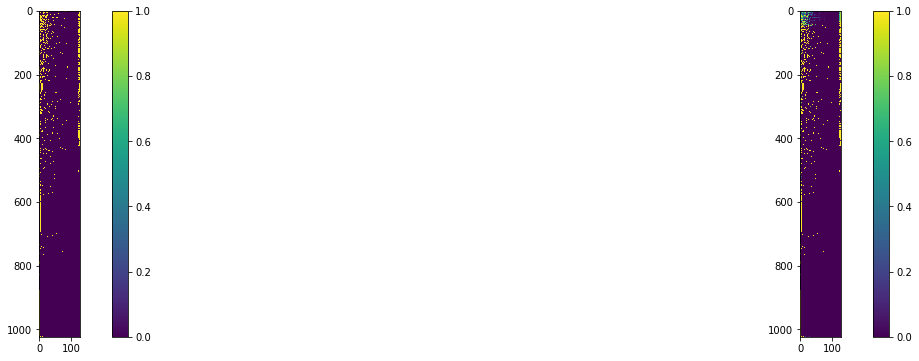

5.580605e-08
0.99027914


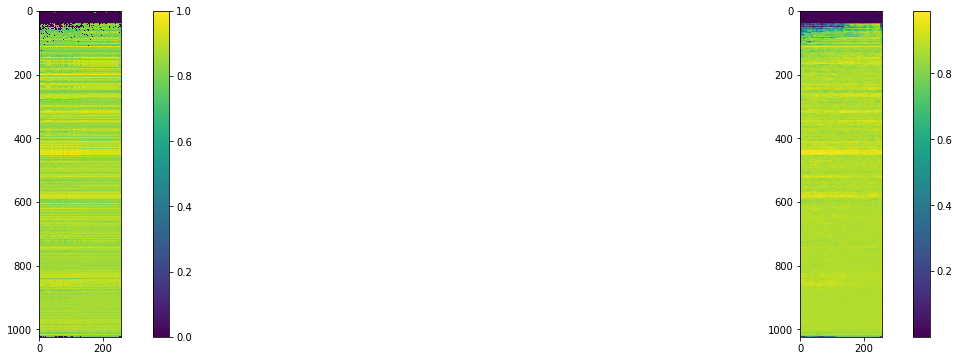

1.5336553e-08
0.44568172


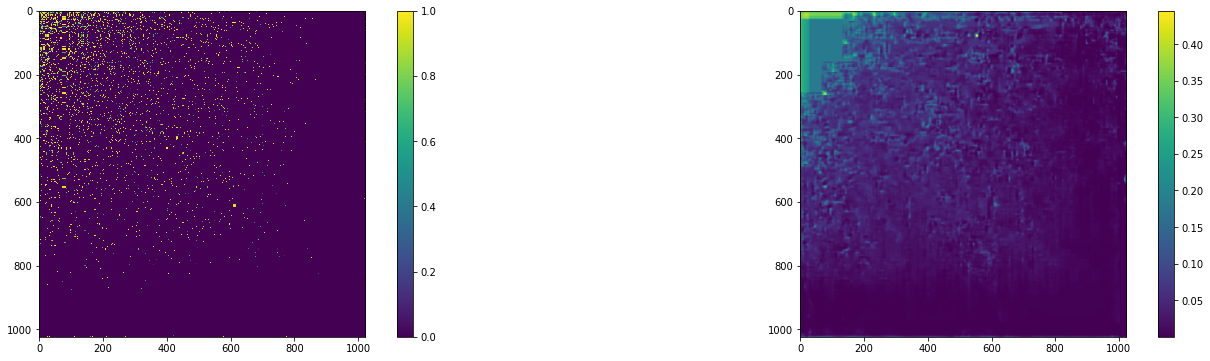

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Experiments/Results/'+ str(numOfExperiment) + '/dicty/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
# color_pack = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model1.org_data)):
    l = model1.predict_data[i]
    l = np.delete(l, [x for x in range(1,model1.predict_data[i].shape[0])], 0)
    print(l.shape)
    model1.predict_data[i] = l;

for i in range(len(model1.org_data)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 6))
    _, row, col, _ = model1.org_data[i].shape
    org_data = model1.org_data[i].reshape((row, col))
    predict = model1.predict_data[i].reshape((row, col))
    
    print(np.min(model1.predict_data[i]))
    print(np.max(model1.predict_data[i]))
    
    
    ax = axes[0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    ax = axes[1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

#     ax = axes[2]
#     im = ax.imshow(predict - org_data, vmin=-1, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    
    plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

    plt.show()


In [8]:
model1.saved_cells_for_test
print(len(model1.saved_cells_for_test[0]))
print("Predict Original Diff \t\tPredict Original Diff \t\tPredict Original Diff")
print("----------------------------------------------------------------------------")
avg_diff = np.zeros(len(model1.saved_cells_for_test))
for i in range(len(model1.saved_cells_for_test[0])):
    for j in range(len(model1.saved_cells_for_test)):
        idx, val = model1.saved_cells_for_test[j][i]
        predict_val = model1.predict_data[j].flatten()[idx]
        diff_abs = np.abs(model1.predict_data[j].flatten()[idx] - val)
        avg_diff[j] += diff_abs
        print(format(predict_val, '.5f') + ' ' + format(val, '.5f') + ' ' + format(diff_abs, '.5f'), end=" \t")
    print()
    
print("---------------------------------------------------------------------------------------")

for i in range(len(avg_diff)):
    val = avg_diff[i]*100/len(model1.saved_cells_for_test[0])
    print("\t\t" + format(val, '.5f') + "%", end="\t")
print()

20
Predict Original Diff 		Predict Original Diff 		Predict Original Diff
----------------------------------------------------------------------------
1.00000 1.00000 0.00000 	0.87360 0.90638 0.03278 	0.20452 0.73498 0.53046 	
0.94252 1.00000 0.05748 	0.86194 0.89746 0.03552 	0.15661 0.99882 0.84221 	
0.99999 1.00000 0.00001 	0.92048 0.94118 0.02071 	0.09834 0.83746 0.73911 	
1.00000 1.00000 0.00000 	0.80164 0.81307 0.01143 	0.18315 0.78799 0.60484 	
0.99532 1.00000 0.00468 	0.87043 0.84445 0.02599 	0.11824 0.93051 0.81227 	
1.00000 1.00000 0.00000 	0.85391 0.82804 0.02587 	0.18315 0.99764 0.81450 	
1.00000 1.00000 0.00000 	0.88591 0.90315 0.01724 	0.04405 0.66549 0.62143 	
0.99770 1.00000 0.00230 	0.84466 0.78024 0.06442 	0.13785 0.86101 0.72317 	
0.46171 1.00000 0.53829 	0.87849 0.78964 0.08885 	0.06707 0.88339 0.81632 	
1.00000 1.00000 0.00000 	0.87357 0.88104 0.00748 	0.23750 0.86219 0.62469 	
1.00000 1.00000 0.00000 	0.85822 0.84410 0.01413 	0.04865 0.79152 0.74287 	
1.00000 1.0000

Correlation coeficient by rows
(1, 1024, 128, 1)


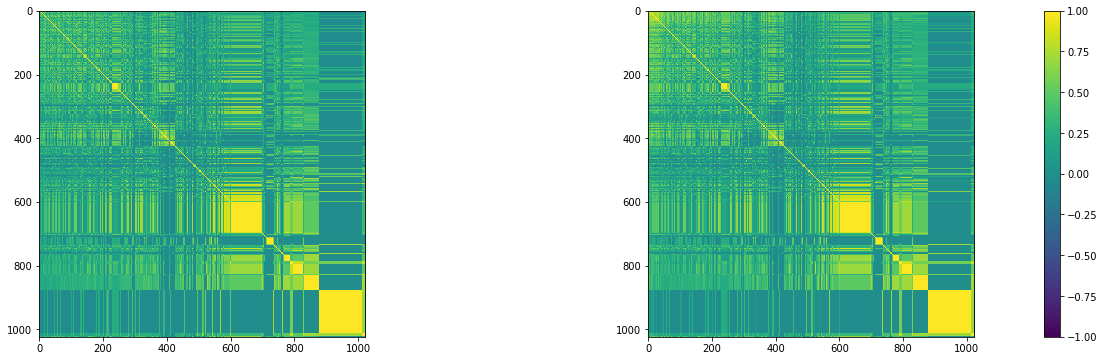

(1, 1024, 256, 1)


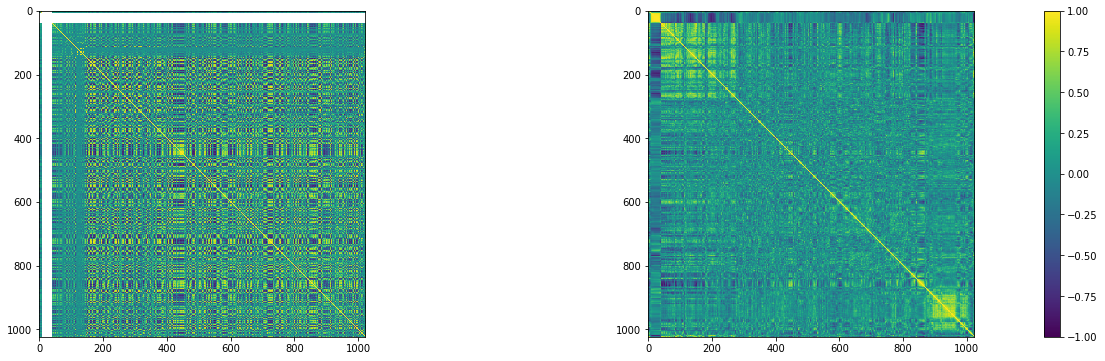

(1, 1024, 1024, 1)


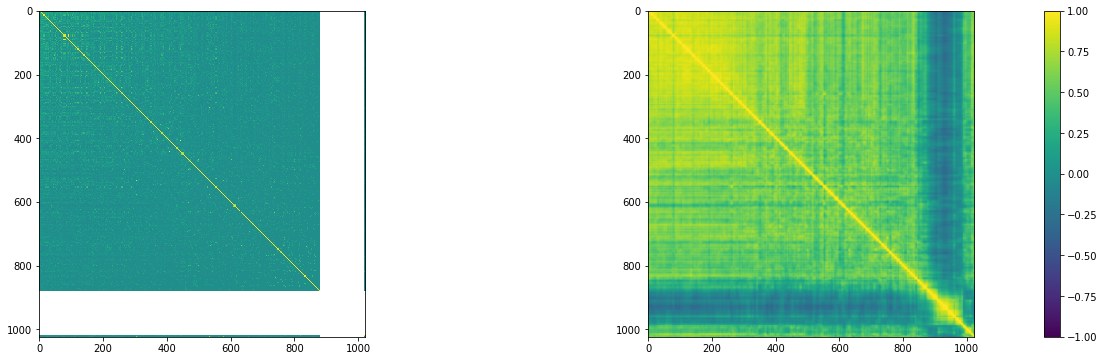

Correlation coeficient by columns
(1, 1024, 128, 1)


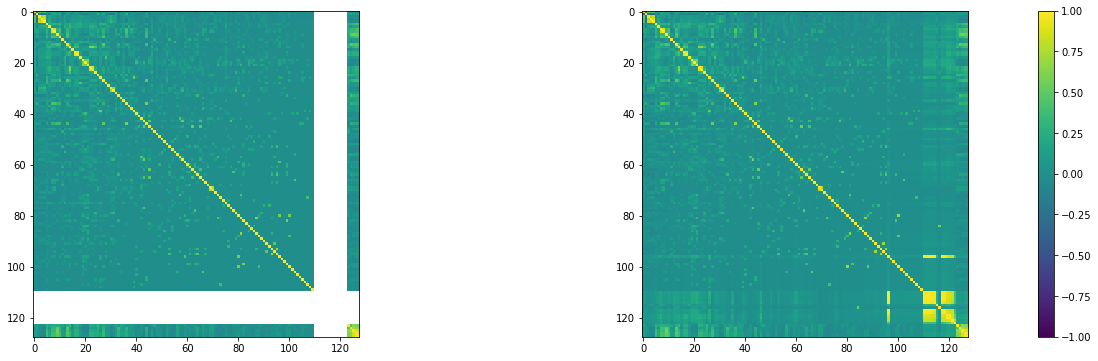

(1, 1024, 256, 1)


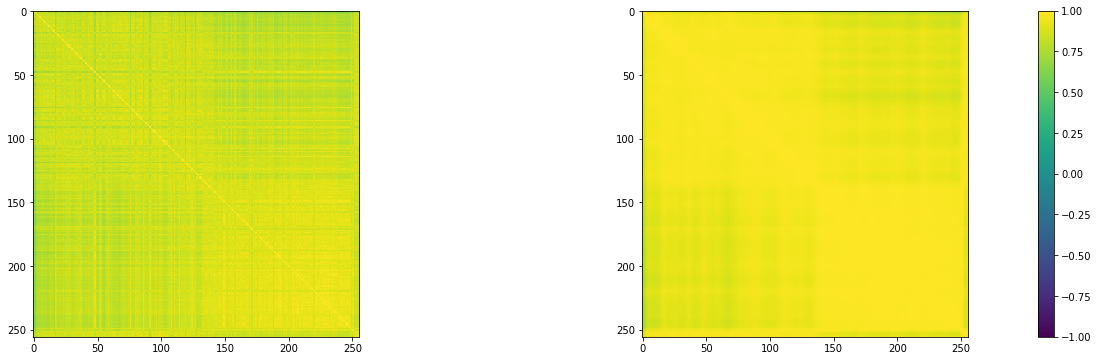

(1, 1024, 1024, 1)


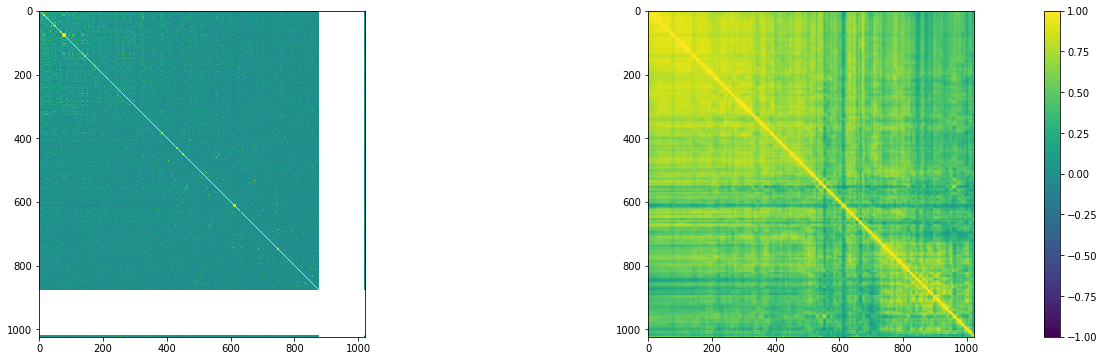

In [11]:
def draw_data(data):
    plt.pcolormesh(data)
    plt.colorbar()
    plt.show()
    
def show_corelation_by_row():
    # color_pack = 'Blues'
    # color_pack = 'jet'
    color_pack = 'viridis'
    # color_pack = 'RdBu'
    # color_pack = 'binary'
    # color_pack = 'PuOr'
    # color_pack = 'rainbow'
    
    for i in range(len(model1.org_data)):
        print(model1.org_data[i].shape)
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 6))
        _, row, col, _ = model1.org_data[i].shape
        org_data = model1.org_data[i].reshape((row, col))
        predict = model1.predict_data[i].reshape((row, col))
        
        org_corr = np.corrcoef(org_data)
        predict_corr = np.corrcoef(predict)

        ax = axes[0]
        im = ax.imshow(org_corr, vmin=-1, vmax=1, cmap=plt.cm.get_cmap(color_pack))

        ax = axes[1]
        im = ax.imshow(predict_corr, vmin=-1, vmax=1, cmap=plt.cm.get_cmap(color_pack))

        

        # fig.colorbar(im, ax=axes.ravel().tolist())
        cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
        plt.colorbar(im, cax=cax, **kw)

        plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_corr_coef(rows).png')

        plt.show()
    
def show_corelation_by_col():
    # color_pack = 'Blues'
    # color_pack = 'jet'
    color_pack = 'viridis'
    # color_pack = 'RdBu'
    # color_pack = 'binary'
    # color_pack = 'PuOr'
    # color_pack = 'rainbow'
    
    for i in range(len(model1.org_data)):
        print(model1.org_data[i].shape)
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 6))
        _, row, col, _ = model1.org_data[i].shape
        org_data = model1.org_data[i].reshape((row, col)).T
        predict = model1.predict_data[i].reshape((row, col)).T
        
        org_corr = np.corrcoef(org_data)
        predict_corr = np.corrcoef(predict)

        ax = axes[0]
        im = ax.imshow(org_corr, vmin=-1, vmax=1, cmap=plt.cm.get_cmap(color_pack))

        ax = axes[1]
        im = ax.imshow(predict_corr, vmin=-1, vmax=1, cmap=plt.cm.get_cmap(color_pack))

        

        # fig.colorbar(im, ax=axes.ravel().tolist())
        cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
        plt.colorbar(im, cax=cax, **kw)

        plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_corr_coef(columns).png')

        plt.show()
    
print('Correlation coeficient by rows')    
show_corelation_by_row()
print('Correlation coeficient by columns') 
show_corelation_by_col()
    

In [ ]:
model = MultiModal(graph=graph2, path='/data/samples/multiple_inputs/pharma/')
model.build_model(optimizer='sgd', loss='mse')
model.fit(500, 30)
model.save('/data/multimodal/pharma/', str(numOfExperiment))
model.predict()

fingerprints	(1260, 920)
actions	(1260, 130)
depo_cats	(189, 16)
depositors	(1260, 189)
pudmed	(1260, 7948)
tanimoto	(1260, 1260)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1260, 920, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1260, 130, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 189, 16, 1)   0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1260, 189, 1) 0                        

Epoch 1/30
490/500 [============================>.] - ETA: 11s - loss: 0.7751 - conv2d_36_loss: 0.1367 - conv2d_37_loss: 0.1428 - conv2d_38_loss: 0.1012 - conv2d_39_loss: 0.2039 - conv2d_40_loss: 0.0742 - conv2d_41_loss: 0.1163

In [5]:
model2 = MultiModal(graph=graph2, path='/data/samples/multiple_inputs/pharma/')
model2.load_model('/data/multimodal/pharma/', str(numOfExperiment))
model2.predict(random=True)

fingerprints	(1260, 920)
actions	(1260, 130)
depo_cats	(189, 16)
depositors	(1260, 189)
pudmed	(1260, 7948)
tanimoto	(1260, 1260)
Data		Density		Predict		BaseLine	AVG Mean		Predict (min)	Predict (max)	
(1260,920) 	13.54% 		12.22585% 	4.3243% 	0.13537 - 0.01059	4e-05		0.22325	
(1260,130) 	4.04% 		4.05256% 	1.47972% 	0.04042 - 0.00123	6e-05		0.15943	
(189,16) 	6.18% 		6.14777% 	2.37852% 	0.06184 - 0.00181	1e-05		0.21067	
(1260,189) 	21.37% 		17.12095% 	6.19327% 	0.2137 - 0.03209	0.00116		0.20945	
(1260,7948) 	0.38% 		0.57259% 	0.34495% 	0.00375 - 9e-05	0.0		0.17579	
(1260,1260) 	99.25% 		7.14392% 	8.59381% 	0.66718 - 0.45333	0.03463		0.92197	


(1260, 920)


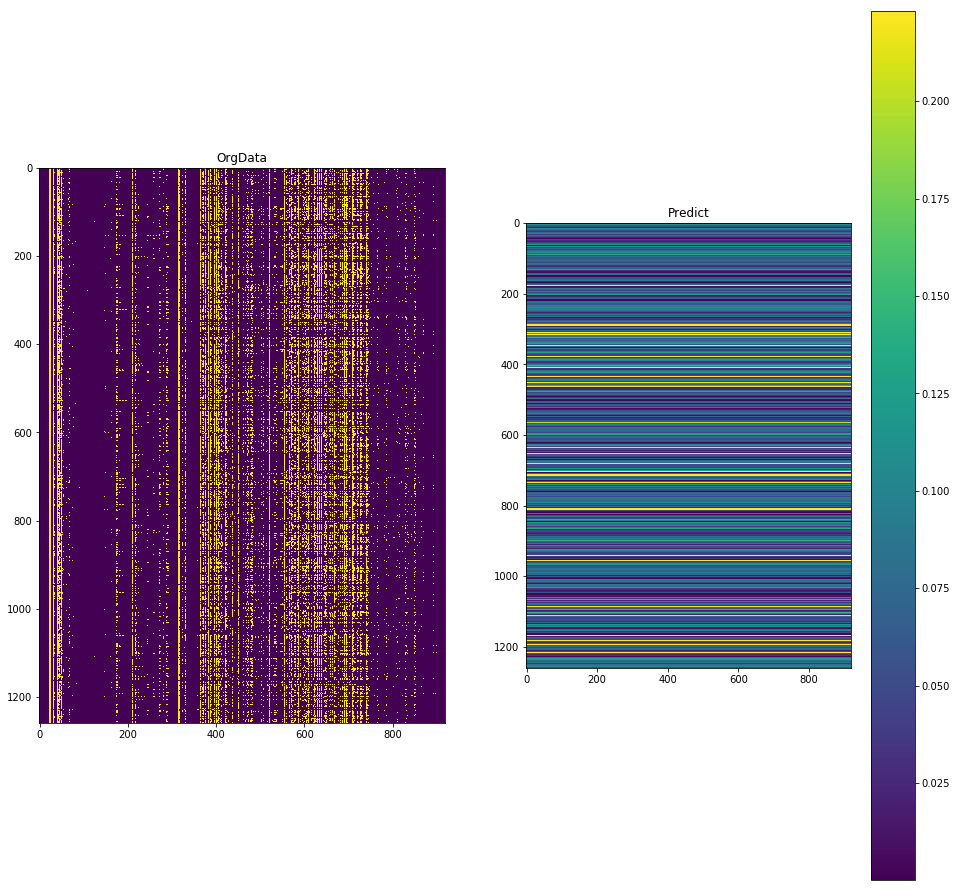

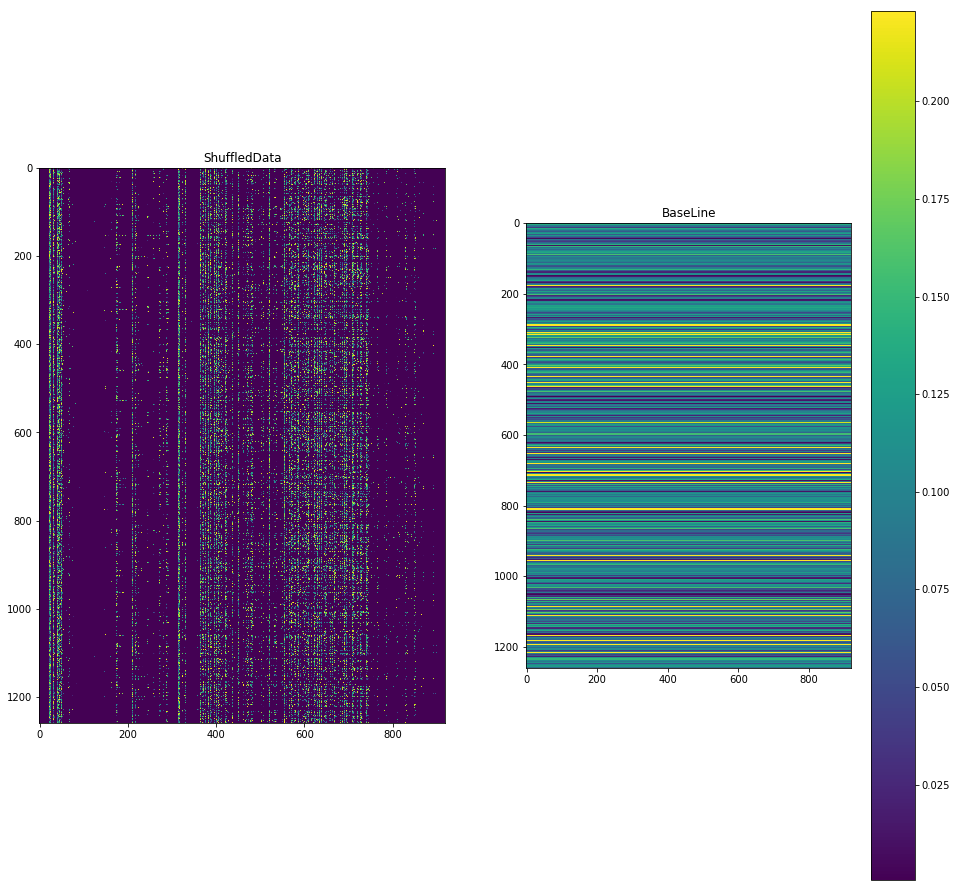

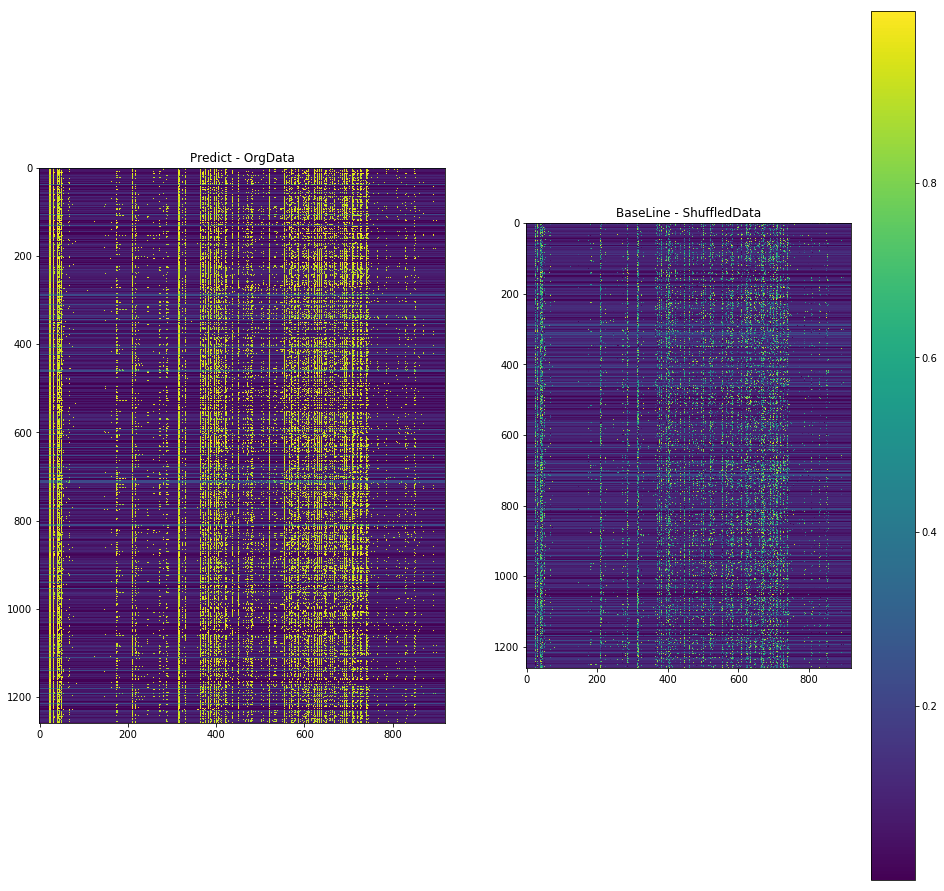

(1260, 130)


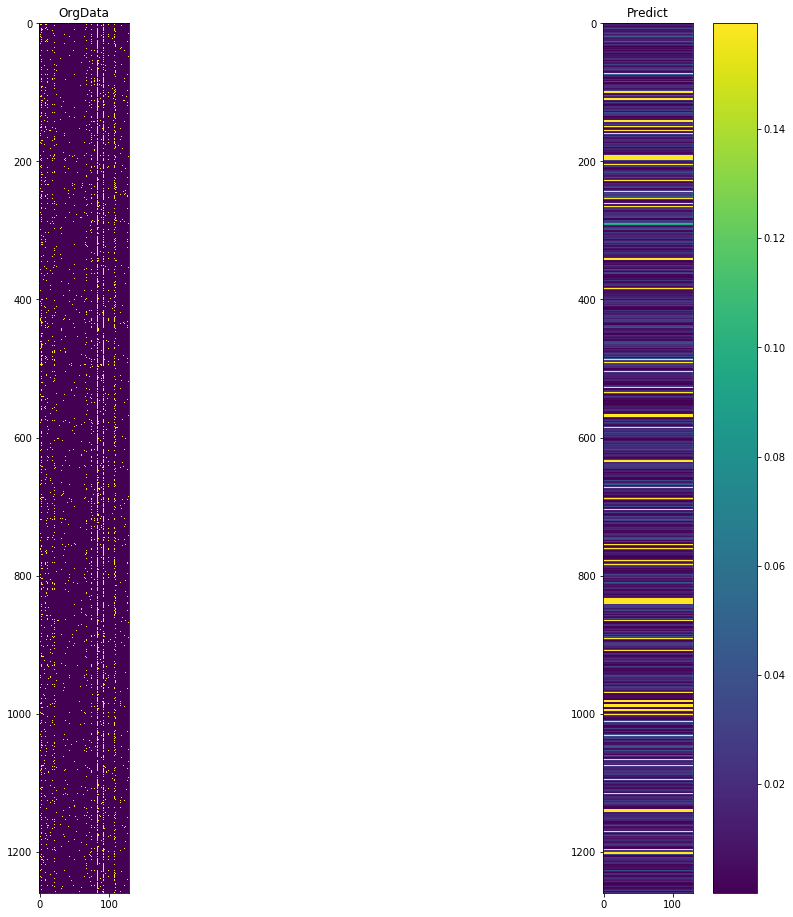

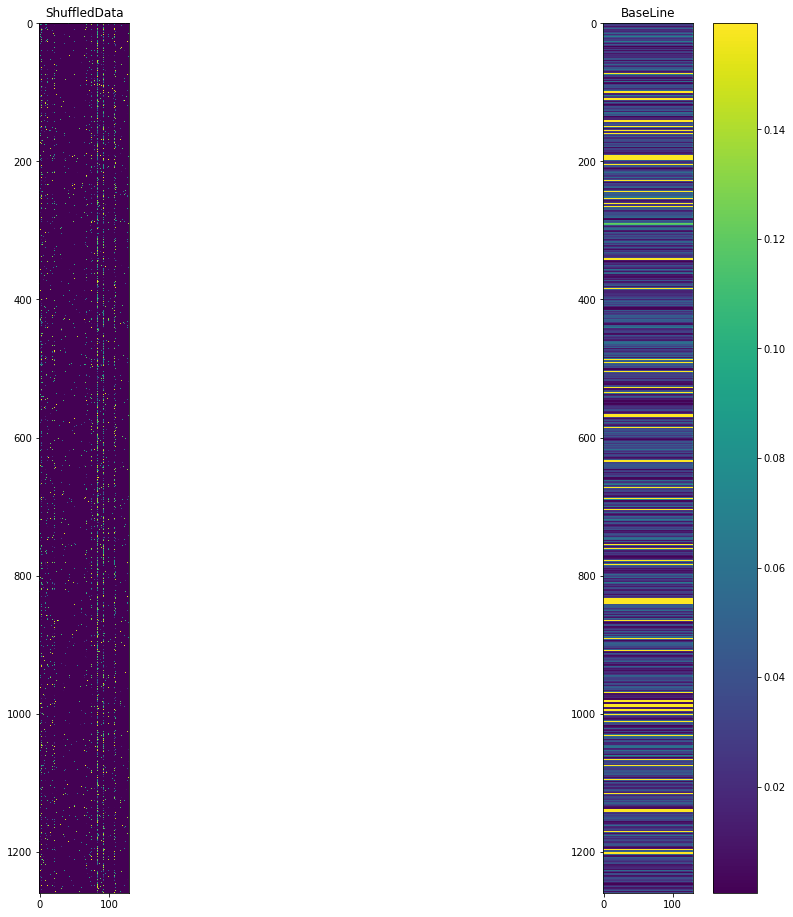

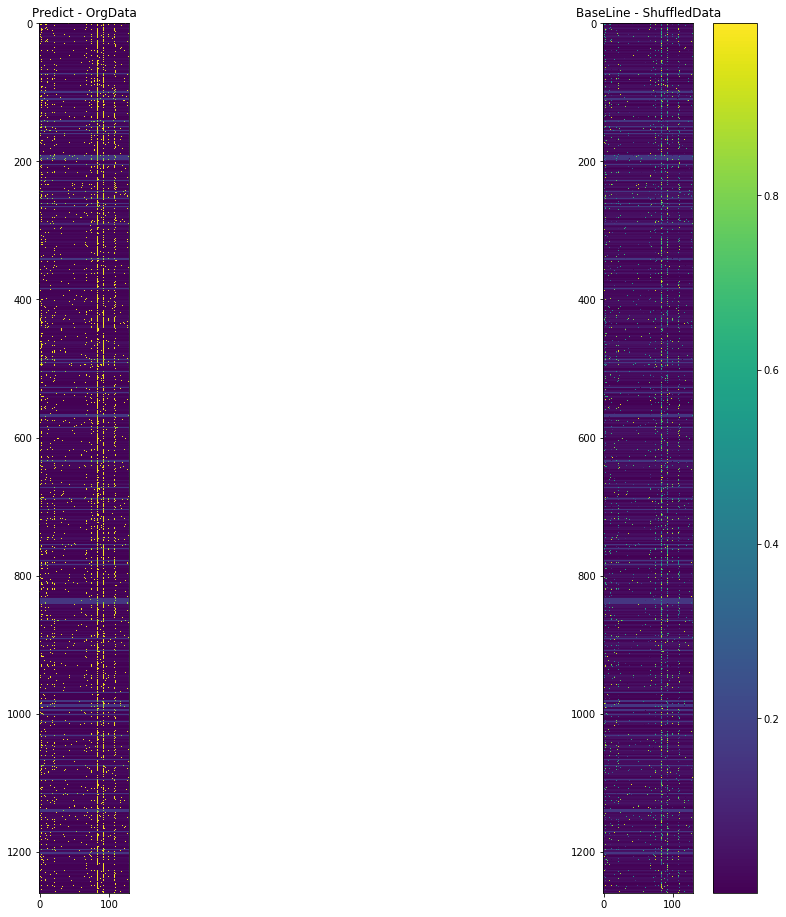

(189, 16)


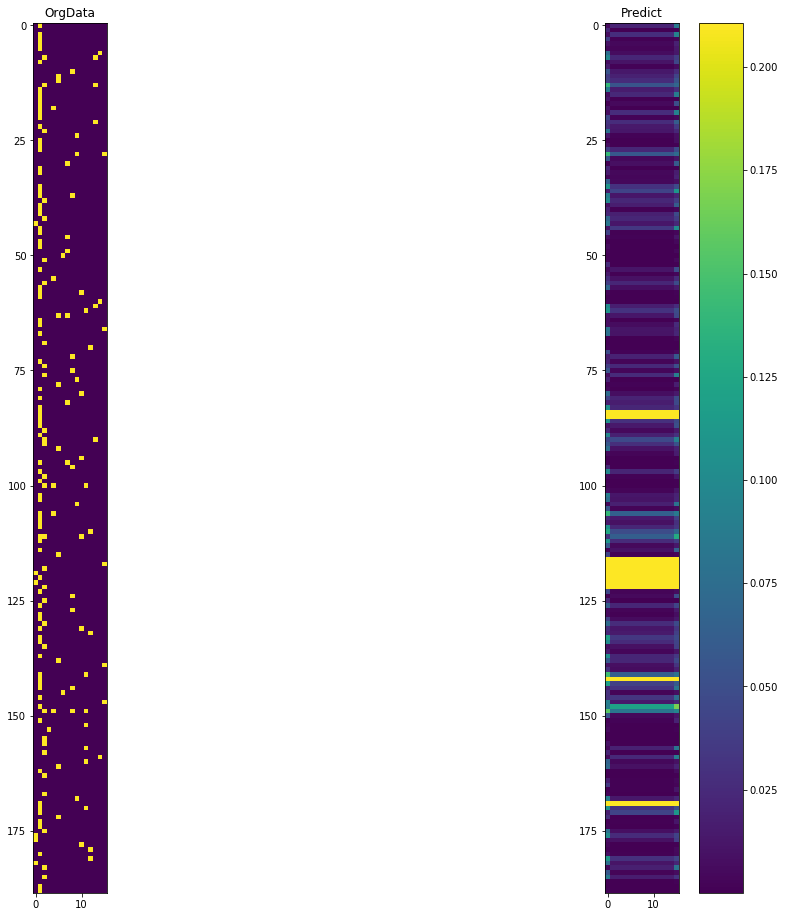

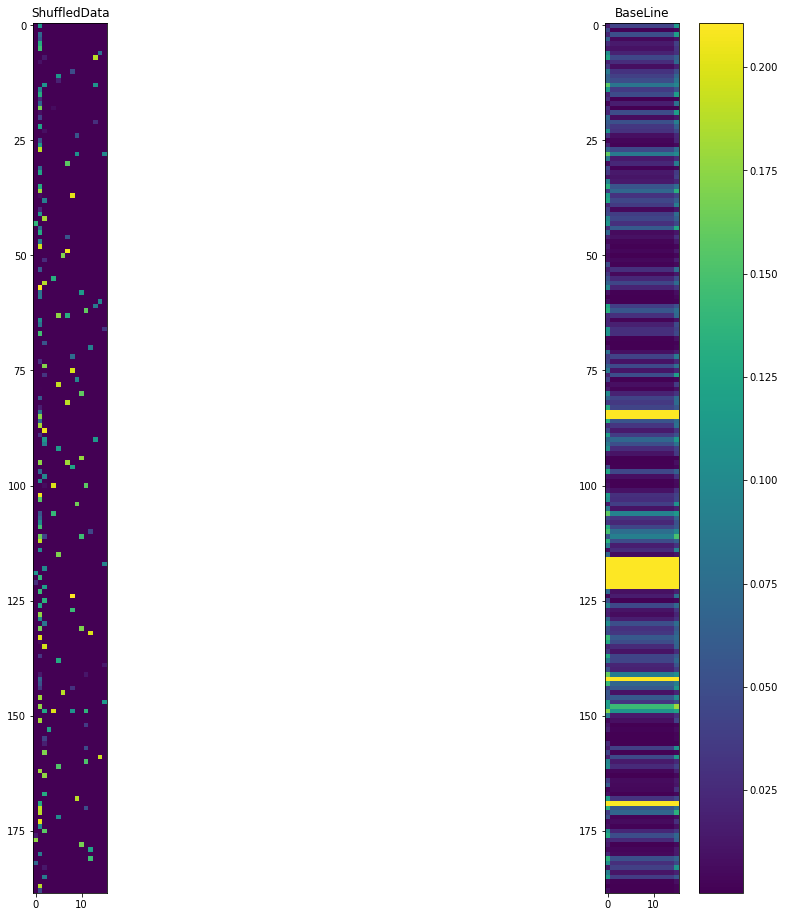

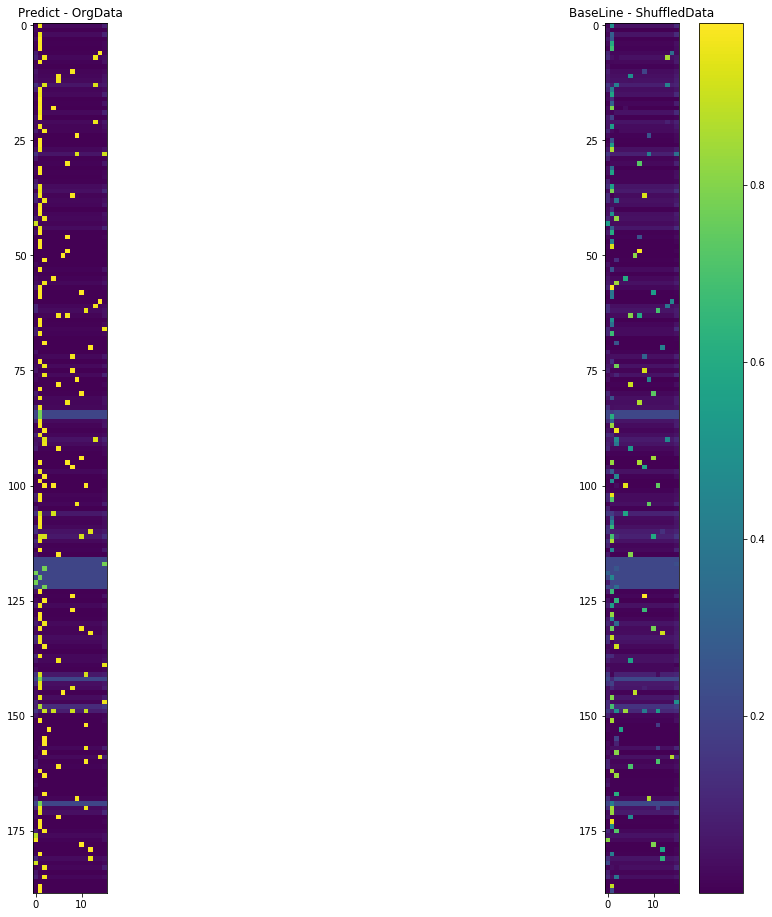

(1260, 189)


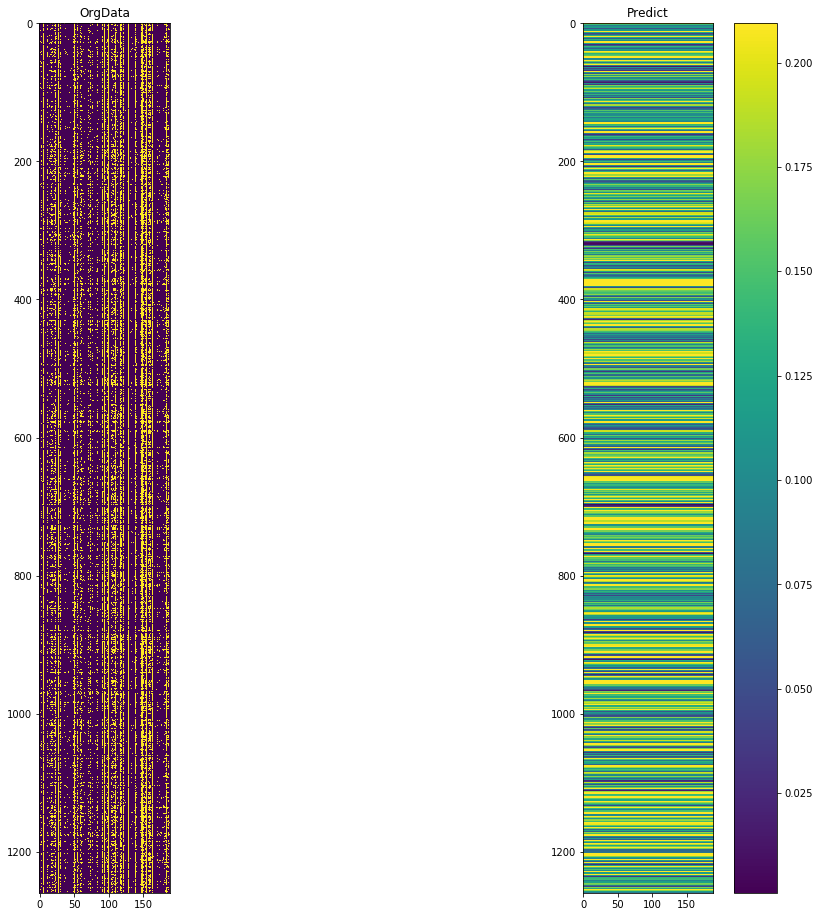

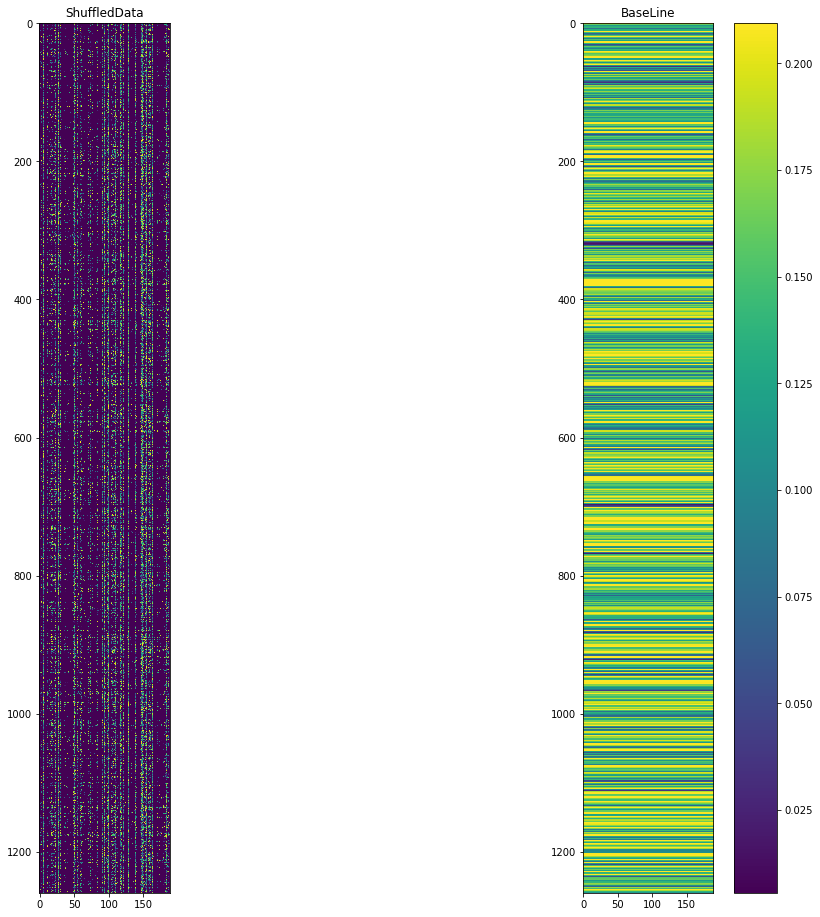

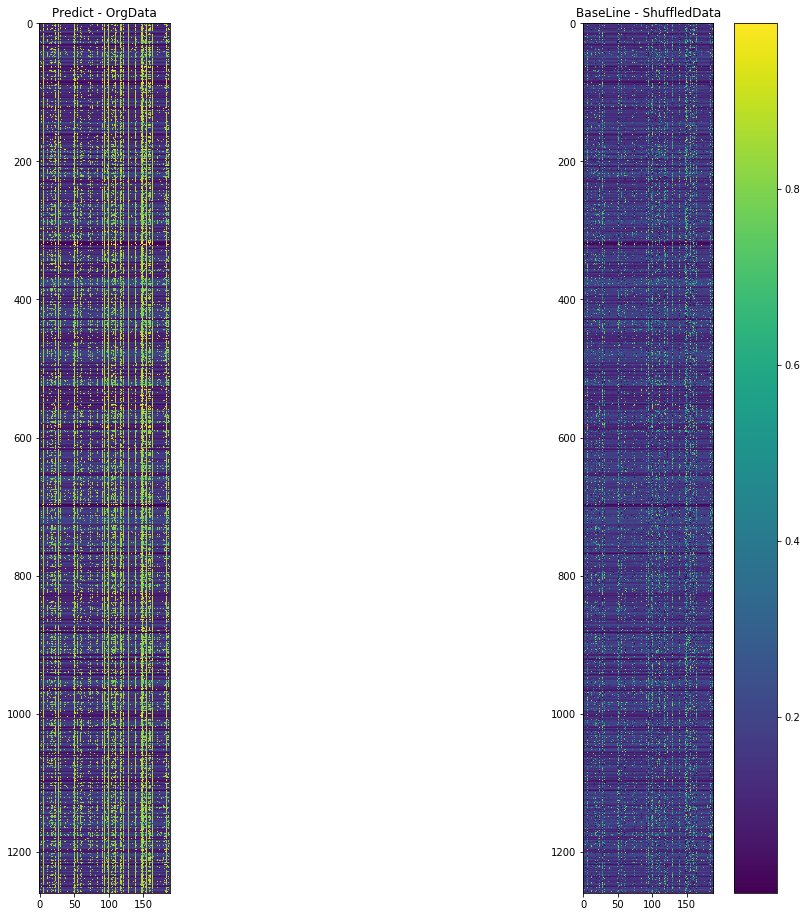

(1260, 7948)


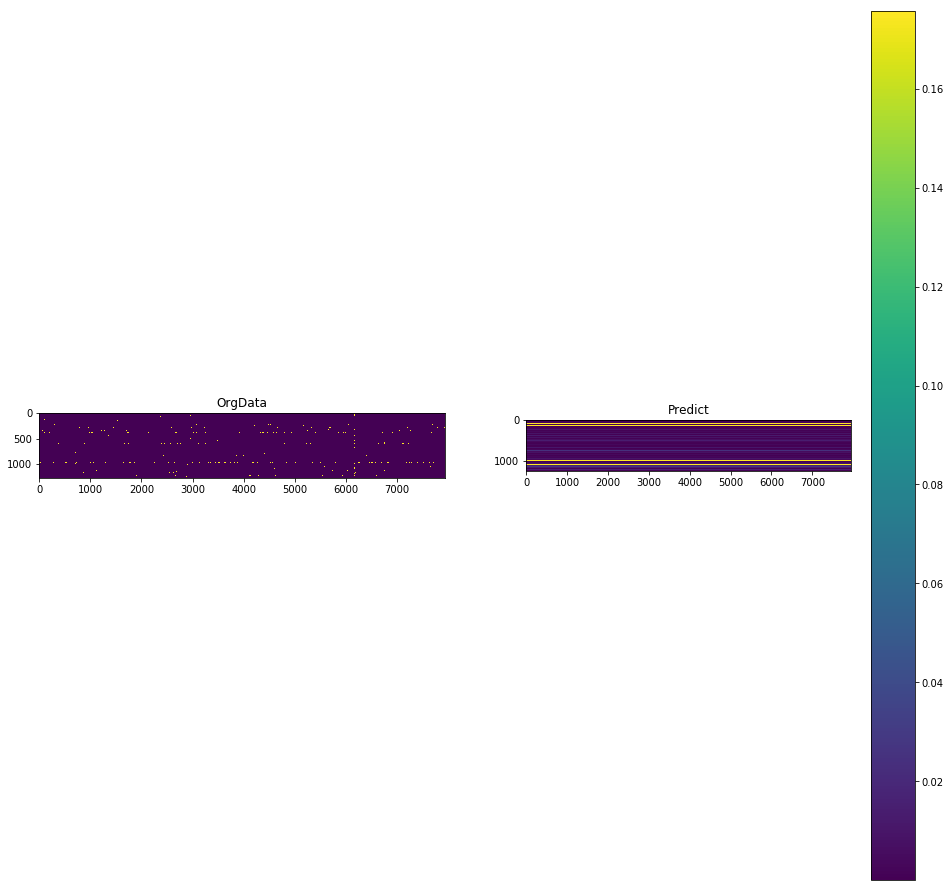

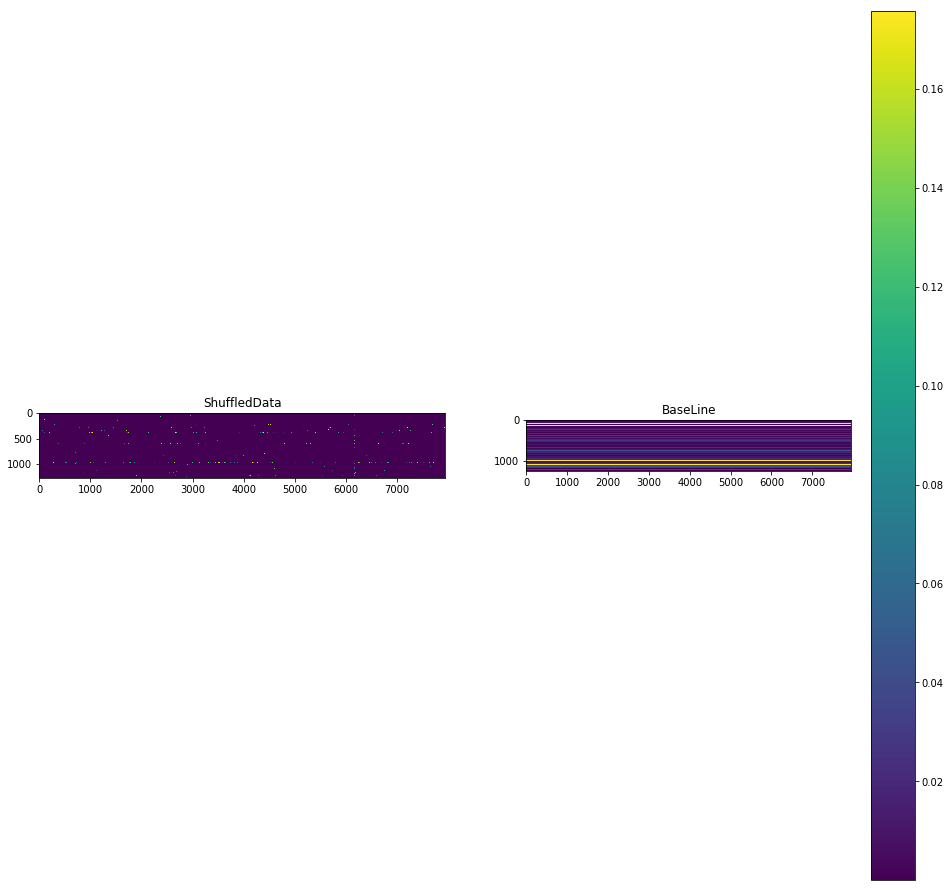

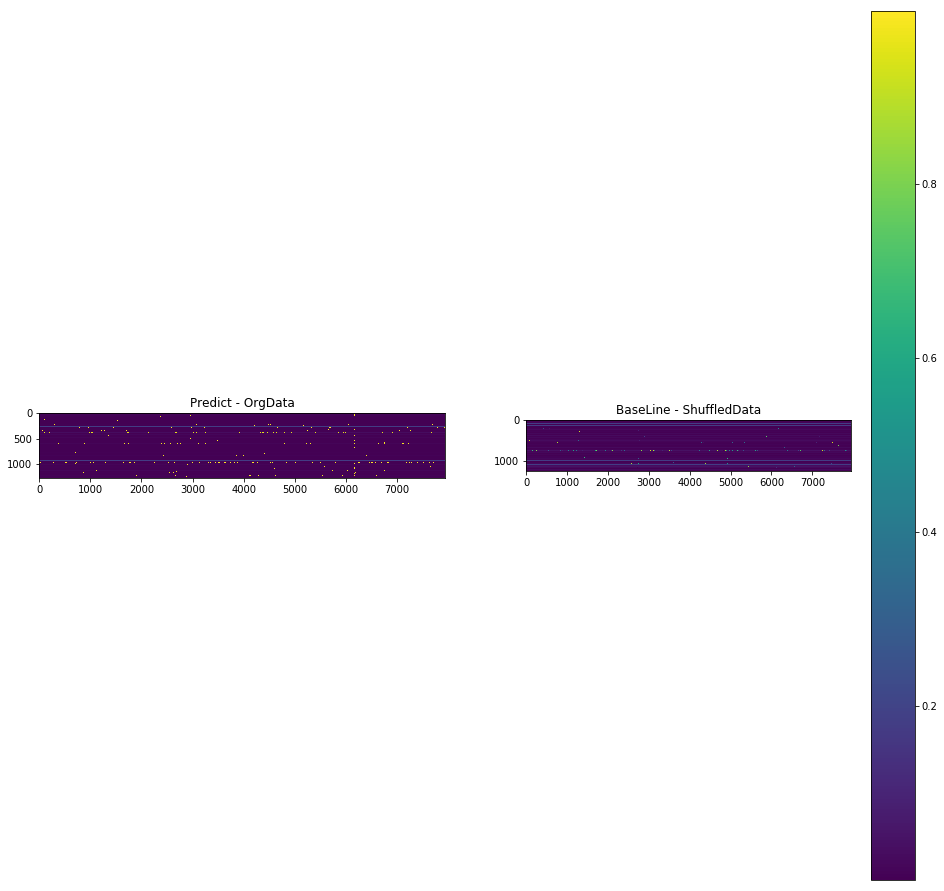

(1260, 1260)


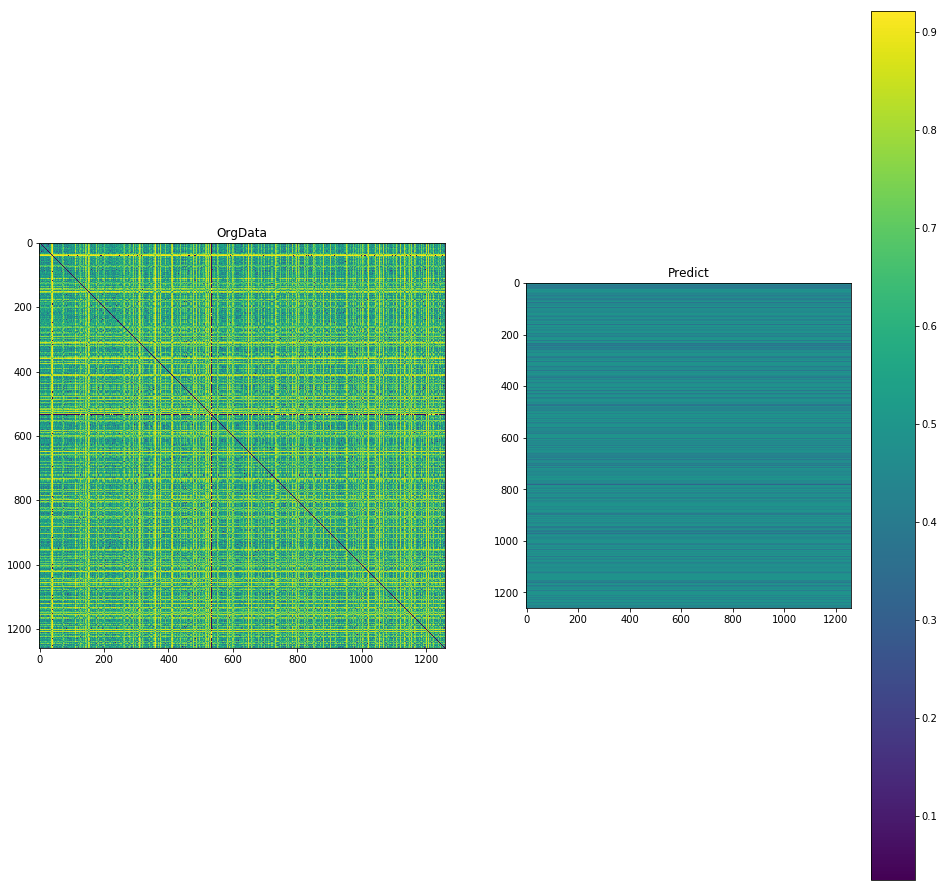

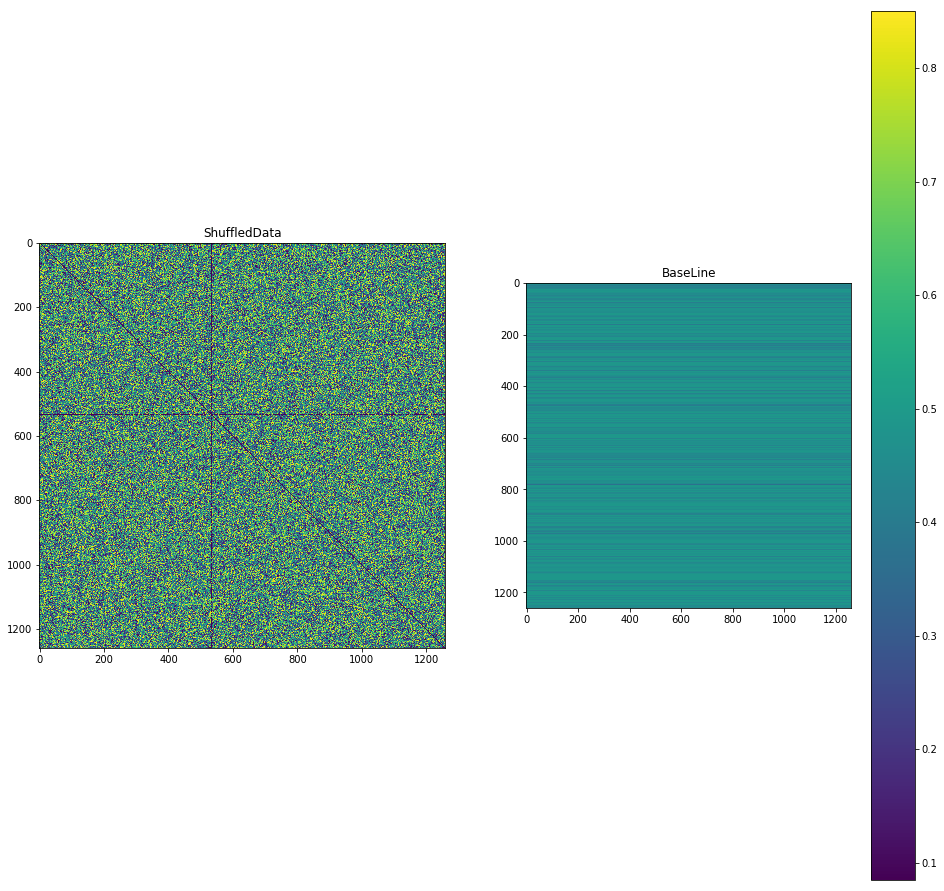

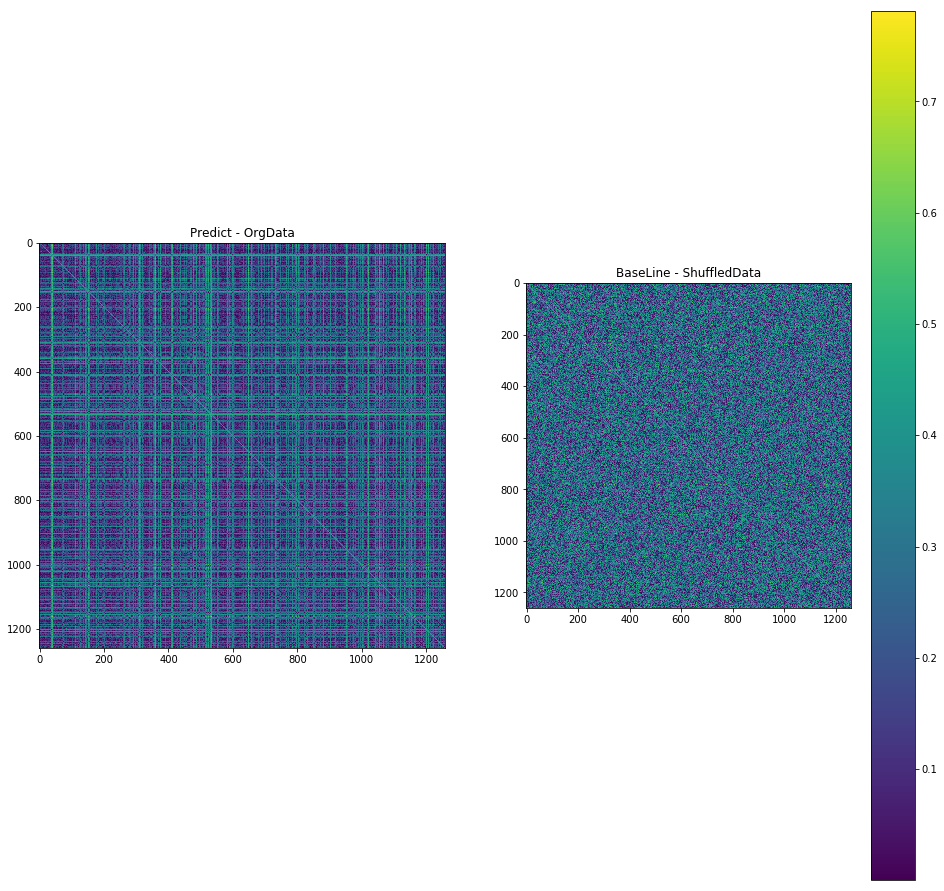

In [7]:
import matplotlib.pyplot as plt

path = '/mag/Experiments/Results/'+ str(numOfExperiment) + '/pharma/'

for i in range(len(model2.org_data)):
    _, row, col, _ = model2.org_data[i].shape
    org_data = model2.org_data[i].reshape(row, col)
    shuffled_data = model2.shuffled_data[i].reshape(row, col)
    predict = model2.predict_data[i].reshape(row, col)
    base_line = model2.base_line[i].reshape(row, col)
    print(org_data.shape)


    fig = plt.figure(figsize=(16,16))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.title.set_text('OrgData')
    plt.imshow(org_data)
    ax1 = fig.add_subplot(1, 2, 2)
    ax1.title.set_text('Predict')
    plt.imshow(predict)
    plt.colorbar()
    plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')
    plt.show()
    plt.close()
    
    fig = plt.figure(figsize=(16,16))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.title.set_text('ShuffledData')
    plt.imshow(shuffled_data)
    ax1 = fig.add_subplot(1, 2, 2)
    ax1.title.set_text('BaseLine')
    plt.imshow(base_line)
    plt.colorbar()
    plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_randomData_vs_predictBaseLine.png')
    plt.show()
    plt.close()
    
    fig = plt.figure(figsize=(16,16))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.title.set_text('Predict - OrgData')
    plt.imshow(np.abs(predict - org_data))
    ax1 = fig.add_subplot(1, 2, 2)
    ax1.title.set_text('BaseLine - ShuffledData')
    plt.imshow(np.abs(base_line - shuffled_data))
    plt.colorbar()
    plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_intersection.png')
    plt.show()
    plt.close()